# Reliability-based Design

Reliability-based design is concerned with mitigating risk to failure under uncertainty of design variables or parameters. In this case, the designer is concerned with lowering the probability that the constraints are violated under uncertainty of the design variables and parameters. In other words, reliable design considers the effect of uncertainty on the constraints. For a reliable design, the deterministic constraints of the optimization problem are changed to ensure that the probability of feasibility of the constraint exceeds a specified reliability level $r$

$$\text{Pr}(g(\textbf{x})\leq0) \geq r$$

If $r$ is set to 0.999, then the constraint must be feasible with a probability of 99.9%. 

To illustrate the idea of reliability-based design, consider the following constrained optimization problem

$$f(x_1,x_2) = x_1^2 - \frac{x_1}{2} - x_2 - 2 $$
$$g_1(x_1,x_2) = x_1^2 -4x_1 + x_2 + 1  \leq 0 $$
$$g_2(x_1,x_2) = \frac{x_1^2}{2} + x_2^2 - x_1 - 4 \leq 0$$
$$-3 \leq x_1 \leq 5 \quad \text{and} \quad -3 \leq x_2 \leq 4$$

This optimization problem was solved using SLSQP in the **Constrained optimization** section of **Local optimization** and the optimum obtained was $f^* = -3.52341$ at $x_1 = 1.06237$ and $x_2 = 2.12086$.

The block of code below imports the necessary packages for this section.

In [27]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import seaborn as sns
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.optimize import minimize
from pymoo.config import Config
Config.warnings['not_compiled'] = False

The block of code below defines the objective and constraint functions of the problem. It also plots the design space with constraint and objective functions along with the optimum point.

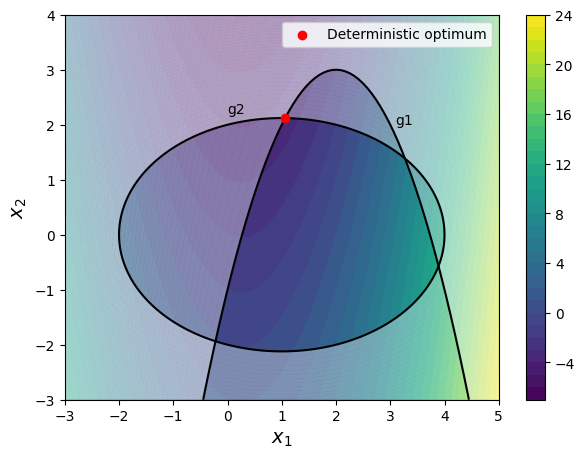

In [28]:
# Functions for fast computations
function_2 = lambda x1, x2: x1**2 - x1/2 - x2 - 2
constraint_1 = lambda x1, x2: x1**2 - 4*x1 + x2 + 1
constraint_2 = lambda x1, x2: x1**2 / 2 + x2**2 - x1 - 4

# Function for optimization
obj = lambda x: function_2(x[0],x[1])

# Defining x and y values
x = np.linspace(-3,5,100)
y = np.linspace(-3,4,100)

# Creating a mesh at which values
# will be evaluated and plotted
X, Y = np.meshgrid(x, y)

# Evaluating the function values at meshpoints
Z = function_2(X,Y)
g1 = constraint_1(X,Y)
g2 = constraint_2(X,Y)

# Plotting the filled contours
fig, ax = plt.subplots(figsize=(7,5))
CS = ax.contourf(X, Y, Z, levels=30)
fig.colorbar(CS, orientation='vertical')

# Plotting g1
ax.contour(X, Y, g1, levels=[0], colors="k")
ax.contourf(X, Y, g1, levels=np.linspace(0,g1.max()), colors="white", alpha=0.35, antialiased = True)
ax.annotate('g1', xy =(3.1, 2.0))

# Plotting g2
ax.contour(X, Y, g2, levels=[0], colors="k")
ax.contourf(X, Y, g2, levels=np.linspace(0,g2.max()), colors="white", alpha=0.35, antialiased = True)
ax.annotate('g2', xy =(0.0, 2.2))

# Optimum point
det_opt_x1 = 1.06237
det_opt_x2 = 2.12086
ax.scatter(det_opt_x1, det_opt_x2, c="r", label="Deterministic optimum", zorder=10)

# Asthetics
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.legend()

Note that the optimum point obtained from deterministic optimization lies at the boundary of both the constraints. Any variation in the constraints can make the point infeasible.

Let $x_1$ and $x_2$ be **normally distributed random variables** with $\sigma_1 = 0.1$ and $\sigma_2 = 0.2$. The block of code below computes the reliability of the deterministic optimum.

In [29]:
# Standard deviation for both variables
x1_sigma = 0.1
x2_sigma = 0.2

# Number of MCS iterations
mcs_samples = 1000000

# Generate random samples
x1 = norm(loc=det_opt_x1, scale=x1_sigma).rvs(size=mcs_samples)
x2 = norm(loc=det_opt_x2, scale=x2_sigma).rvs(size=mcs_samples)

# Compute value of constraints at those x values
g1_value = constraint_1(x1, x2)
g2_value = constraint_2(x1, x2)

# Compute reliabiltiy for both constraints
# It involves counting how many values satisfy the 
# constraints and compute the fraction.
rel_g1 = len(g1_value[g1_value <= 0])/mcs_samples
rel_g2 = len(g2_value[g2_value <= 0])/mcs_samples

# Printing the results
print("Reliability of g1: {}".format(rel_g1))
print("Reliability of g2: {}".format(rel_g2))
print("Total reliability: {} (assuming both the constraints are independent)".format(rel_g1 * rel_g2))

Reliability of g1: 0.491725
Reliability of g2: 0.497204
Total reliability: 0.2444876369 (assuming both the constraints are independent)


The above calculations indicate that this optimum point has bad reliability. Hence, there is a need for reliability-based optimization. The problem statement will be:

$$
    \begin{aligned}
        \min_{x_1, x_2} \quad & f(x_1, x_2) \\
        \textrm{s.t.} \quad & P[g_1(x_1, x_2) \leq 0] \geq 0.99 \\
          & P[g_2(x_1, x_2) \leq 0] \geq 0.99 \\
    \end{aligned}
$$


**<font >Note</font>**: The objective function is kept deterministic here.

The block of code below defines two functions for computing the reliability for each constraint.

In [30]:
# Few parameters
x1_sigma = 0.1
x2_sigma = 0.2
mcs_samples = 1000000
reliability = 0.99

def rel_con1(x):
    """
        Function for computing reliability of g1.
    """
    
    # Generate random samples
    x1 = norm(loc=x[0], scale=x1_sigma).rvs(size=mcs_samples)
    x2 = norm(loc=x[1], scale=x2_sigma).rvs(size=mcs_samples)
    
    # Compute value of constraint at those x values
    g1_value = constraint_1(x1, x2)
    
    # Computing frequency of feasible x
    return reliability - len(g1_value[g1_value <= 0])/mcs_samples

def rel_con2(x):
    """
        Function for computing reliability of g2.
    """
    
    # Generate random samples
    x1 = norm(loc=x[0], scale=x1_sigma).rvs(size=mcs_samples)
    x2 = norm(loc=x[1], scale=x2_sigma).rvs(size=mcs_samples)
    
    # Compute value of constraint at those x values
    g2_value = constraint_2(x1, x2)
    
    # Computing frequency of feasible x
    return reliability - len(g2_value[g2_value <= 0])/mcs_samples

The block of code below performs reliability-based optimization.

Here, *differential evolution* (DE) is used as an optimizer. As explained earlier, gradient-based optimizers don't work well since gradients can be difficult to compute. Since DE involves lots of function evaluations and at each iteration, MCS is performed several times, the optimization will take longer to run.

In [31]:
# Defining a generic differential evolution problem
class ReliableDesign(ElementwiseProblem):

    def __init__(self):
        super().__init__(n_var=2, n_obj=1, n_ieq_constr=2, xl=np.array([-3,-3]), xu=np.array([5,4]))

    def _evaluate(self, x, out, *args, **kwargs):
        out["F"] = function_2(x[0],x[1])
        out["G"] = np.column_stack((rel_con1(x), rel_con2(x)))

problem = ReliableDesign()

algorithm = DE(pop_size=20, CR=0.8, dither="vector")

In [32]:
termination = DefaultSingleObjectiveTermination(
    xtol=1e-3,
    cvtol=1e-3,
    ftol=1e-3,
    period=10,
    n_max_gen=1000,
    n_max_evals=100000
)

res = minimize(problem, algorithm, termination=termination, verbose=False, 
               save_history=True)

print("Best solution found: \nX = %s\nF = %s" % (res.X, res.F))

rel_opt_x1 = res.X[0]
rel_opt_x2 = res.X[1]

Best solution found: 
X = [1.15105502 1.63884119]
F = [-2.88944104]


In [33]:
mcs_samples = 1000000

x1 = norm(loc=rel_opt_x1, scale=x1_sigma).rvs(size=mcs_samples)
x2 = norm(loc=rel_opt_x2, scale=x2_sigma).rvs(size=mcs_samples)

g1_value = constraint_1(x1, x2)
g2_value = constraint_2(x1, x2)

rel_g1 = len(g1_value[g1_value <= 0])/mcs_samples
rel_g2 = len(g2_value[g2_value <= 0])/mcs_samples

print("Reliability of g1: {}".format(rel_g1))
print("Reliability of g2: {}".format(rel_g2))
print("Total reliability: {} (assuming both the constraints are independent)".format(rel_g1 * rel_g2))

Reliability of g1: 0.990105
Reliability of g2: 0.991788
Total reliability: 0.98197425774 (assuming both the constraints are independent)


So, the design point is much more reliable as compared to deterministic optimum. But the optimum value is also increased. The block of code below plots the design space with both the deterministic and reliable optimum.

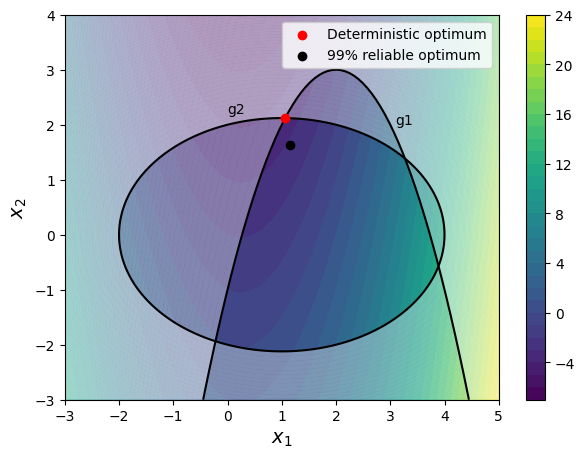

In [34]:
# Defining x and y values
x = np.linspace(-3,5,100)
y = np.linspace(-3,4,100)

# Creating a mesh at which values
# will be evaluated and plotted
X, Y = np.meshgrid(x, y)

# Evaluating the function values at meshpoints
Z = function_2(X,Y)
g1 = constraint_1(X,Y)
g2 = constraint_2(X,Y)

# Plotting the filled contours
fig, ax = plt.subplots(figsize=(7,5))
CS = ax.contourf(X, Y, Z, levels=30)
fig.colorbar(CS, orientation='vertical')

# Plotting g1
ax.contour(X, Y, g1, levels=[0], colors="k")
ax.contourf(X, Y, g1, levels=np.linspace(0,g1.max()), colors="white", alpha=0.35, antialiased = True)
ax.annotate('g1', xy =(3.1, 2.0))

# Plotting g2
ax.contour(X, Y, g2, levels=[0], colors="k")
ax.contourf(X, Y, g2, levels=np.linspace(0,g2.max()), colors="white", alpha=0.35, antialiased = True)
ax.annotate('g2', xy =(0.0, 2.2))

# Optimum point
ax.scatter(det_opt_x1, det_opt_x2, c="r", label="Deterministic optimum", zorder=10)
ax.scatter(rel_opt_x1, rel_opt_x2, c="k", label="99% reliable optimum", zorder=10)

# Asthetics
ax.set_xlabel("$x_1$", fontsize=14)
ax.set_ylabel("$x_2$", fontsize=14)
ax.legend()

The reliability value can be changed to see how the optimum point changes.

Robust and reliability-based optimization can be combined by using some combination of mean and standard deviation of $f$ as an objective with reliability constraints.